# Project: Wrangling and Analyze Data

In [1]:
#importing packages
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import seaborn as sns

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
ratingDogsDF=pd.read_csv("twitter_archive_enhanced.csv")
#ratingDogsDF[ratingDogsDF.pupper!="None"]

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
imageTSV=requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv', 'w') as file: 
	file.write(imageTSV.text)

In [4]:
image_predict=pd.read_csv('image_predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

# Tweet IDs for which to gather additional data via Twitter's API
#tweet_ids = ratingDogsDF.tweet_id.values
#len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#           fails_dict[tweet_id] = e
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [6]:
ratingDogsDF.tweet_id.duplicated().value_counts() #checking to see if there are any duplicated tweets
ratingDogsDF[ratingDogsDF.rating_denominator.isna()==True] #checking to make sure there is a denominator

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [7]:
image_predict.jpg_url[image_predict.jpg_url.str.endswith('.jpg')== False] #checking to make sure the syntax for the urls is consistent

320    https://pbs.twimg.com/tweet_video_thumb/CVKtH-...
815    https://pbs.twimg.com/tweet_video_thumb/CZ0mhd...
Name: jpg_url, dtype: object

In [8]:
#creating a dataframe by importing the file created from the api data
tweet_df = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        tweet_df = tweet_df.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'retweet_count', 'favorite_count']))
tweet_df = tweet_df.reset_index(drop=True)

In [9]:
#checking to make sure the new dataframe was made correctly. 
tweet_df.head()
tweet_df.info()#2328

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
tweet_id          2328 non-null object
retweet_count     2328 non-null object
favorite_count    2328 non-null object
dtypes: object(3)
memory usage: 54.6+ KB


### Quality issues
1. For ratingDogsDf, Some of the 'name' objects aren't actually names

2. For image_predict, there are inconsistent or non-existent dog breeds in p1, p2 and p3

3. For ratingDogsDF,  the rating_numerator and rating_denominator columns should be a float. 

4. For image_predict, two of the jpg_urls are incomplete (endswith (...))

5. For ratingDogsDF, retweeted_status.timestamp and timestamp are objects and should not be 

6. For ratingDogsDF, retweets and replies are not necessary for our examination. 

7. The remaining IDs should all be qualitative

8. For ratingDogsDF, we will get rid of "None" values in the doggo - puppo columns and replace with null, then melt the columns together. 

### Tidiness issues
9. There are a lot of null values in rd_df columns doggo, floofer, puppo, and pupper.

10. Merge data frames on shared tweet_ids.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [10]:
# Make copies of original pieces of data
rd_df=ratingDogsDF.copy()
ip_df=image_predict.copy()
tt_df=tweet_df.copy()

### Issue #1: Some of the 'name' objects aren't actually names in rd_df.

#### Define: Replace values where text is not a name. 

#### Code

In [11]:
#creating a list of words that need to go then replacing them with None values. 
not_dog_names=["", 'a','an','the', 'very', 'unacceptable', 'this', 'such', 'quite', 'one', 'old', 'officially', 'not', 'my', 'mad', 'light', 'life', 'just', 'space', 'infuriating', 'incredible', 'incredibly', 'his', 'getting', 'by', 'all', 'actually']
rd_df.name.replace(not_dog_names, None, inplace=True)

In [12]:
#checking to see if I've missed any
list(rd_df.name.sort_values())[:20]

['Abby',
 'Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albert',
 'Albert',
 'Albus',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie']

#### Test

In [13]:
#final test to confirm replace worked
list(dict(rd_df.name.value_counts()))[:20]

['None',
 'Oliver',
 'Charlie',
 'Cooper',
 'Lucy',
 'Tucker',
 'Lola',
 'Penny',
 'Bo',
 'Winston',
 'Sadie',
 'Daisy',
 'Buddy',
 'Dave',
 'Stanley',
 'Toby',
 'Bailey',
 'Scout',
 'Koda',
 'Bella']

### Issue #2: There are inconsistent or non-existent dog breeds in p1-p3 in ip_df

#### Define:  In ip_df there are dog breeds that don't exist or are in an inconsistent format. We will dismiss these values

#### Code

In [14]:
#finding words that are not dogbreeds 
p1_dict=dict(ip_df.p1.value_counts())

In [15]:
p2_dict=dict(ip_df.p2.value_counts())

In [16]:
p3_dict=dict(ip_df.p3.value_counts())

In [17]:
#the dictionary of not dogbreeds from the above dictionaries
not_dog_breeds={'kelpie': 35, 'doormat': 16, 'seat_belt': 15, 'dingo': 15, 'Siamese_cat': 12, 'white_wolf': 10, 'toilet_tissue': 7, 'bathtub': 7, 'ice_bear': 6, 'muzzle': 6, 'tennis_ball': 5, 'water_buffalo': 5, 'bath_towel': 5, 'sandbar': 5, 'hog': 5, 'Persian_cat': 5, 'Arctic_fox': 5, 'black_footed_ferret': 5, 'weasel': 5, 'paper_towel': 4, 'sea_lion': 4, 'quilt': 4, 'television': 4, 'wallaby': 4, 'three_toed_sloth': 4, 'sombrero': 4, 'ice_lolly': 4, 'fountain': 4, 'swing': 4, 'fur_coat': 4, 'printer': 3, 'microwave': 3, 'scuba_diver': 3, 'tub': 3, 'gibbon': 3, 'racket': 3, 'menu': 3, 'echidna': 3, 'sundial': 3, 'bubble': 3, 'carton': 3, 'koala': 3, 'bagel': 3, 'ski_mask': 3, 'purse': 3, 'hamster': 3, 'crane': 3, 'bookcase': 3, 'limousine': 3, 'Arabian_camel': 3, 'sunglasses': 3, 'box_turtle': 3, 'pillow': 3, 'guinea_pig': 3, 'umbrella': 3, 'polecat': 3, 'macaque': 3, 'shower_curtain': 3, 'wood_rabbit': 3, 'wool': 3, 'cougar': 2, 'common_iguana': 2, 'snow_leopard': 2, 'shopping_cart': 2, 'king_penguin': 2, 'bassinet': 2, 'Egyptian_cat': 2, 'brass': 2, 'llama': 2, 'file': 2, 'space_heater': 2, 'washbasin': 2, 'Christmas_stocking': 2, 'mouse': 2, 'agama': 2, 'bucket': 2, 'pizza': 2, 'prison': 2, 'convertible': 2, 'French_loaf': 2, 'beacon': 2, 'hen': 2, 'car_wheel': 2, 'bolete': 2, 'komondor': 2, 'refrigerator': 2, 'book_jacket': 2, 'coyote': 2, 'ram': 2, 'leafhopper': 2, 'swab': 2, 'paddlewheel': 2, 'badger': 2, 'bathing_cap': 2, 'giant_panda': 2, 'Angora': 2, 'beaver': 2, 'sliding_door': 2, 'shopping_basket': 2, 'jigsaw_puzzle': 2, 'abaya': 2, 'ashcan': 2, 'mask': 2, 'mousetrap': 2, 'titi': 2, 'bison': 2, 'squirrel_monkey': 2, 'warthog': 2, 'Bouvier_des_Flandres': 2, 'envelope': 2, 'lumbermill': 2, 'feather_boa': 2, 'toilet_seat': 2, 'hippopotamus': 2, 'minibus': 2, 'terrapin': 2, 'poncho': 2, 'wreck': 2, 'lakeside': 2, 'wig': 2, 'panpipe': 1, 'maraca': 1, 'conch': 1, 'viaduct': 1, 'can_opener': 1, 'hand_blower': 1, 'grocery_store': 1, 'goose': 1, 'loupe': 1, 'red_wolf': 1, 'traffic_light': 1, 'lampshade': 1, 'chime': 1, 'mink': 1, 'zebra': 1, 'parachute': 1, 'Indian_elephant': 1, 'sea_cucumber': 1, 'padlock': 1, 'switch': 1, 'goldfish': 1, 'snail': 1, 'entertainment_center': 1, 'assault_rifle': 1, 'European_fire_salamander': 1, 'power_drill': 1, 'whiptail': 1, 'bow_tie': 1, 'barbell': 1, 'American_black_bear': 1, 'toyshop': 1, 'plunger': 1, 'broccoli': 1, 'greenhouse': 1, 'rock_crab': 1, 'space_shuttle': 1, 'wombat': 1, 'bow': 1, 'chain': 1, 'plastic_bag': 1, 'otter': 1, 'eel': 1, 'rotisserie': 1, 'barrow': 1, 'paintbrush': 1, 'rapeseed': 1, 'vacuum': 1, 'joystick': 1, 'wolf_spider': 1, 'boathouse': 1, 'ballplayer': 1, 'shoji': 1, 'African_chameleon': 1, 'go-kart': 1, 'bonnet': 1, 'drumstick': 1, 'wild_boar': 1, 'Windsor_tie': 1, 'cheetah': 1, 'rain_barrel': 1, 'cliff': 1, 'hand-held_computer': 1, 'croquet_ball': 1, 'wallet': 1, 'lion': 1, 'golfcart': 1, 'quill': 1, 'chimpanzee': 1, 'valley': 1, 'notebook': 1, 'bannister': 1, 'common_newt': 1, 'mosquito_net': 1, 'maze': 1, 'tiger_cat': 1, 'beach_wagon': 1, 'electric_fan': 1, 'chest': 1, 'window_screen': 1, 'jersey': 1, 'sunglass': 1, 'rhinoceros_beetle': 1, 'soccer_ball': 1, 'cowboy_boot': 1, 'Band_Aid': 1, 'mitten': 1, 'cuirass': 1, 'passenger_car': 1, 'canoe': 1, 'pajama': 1, 'partridge': 1, 'French_horn': 1, 'theater_curtain': 1, 'crayfish': 1, 'loggerhead': 1, 'axolotl': 1, 'moped': 1, 'grey_fox': 1, 'mushroom': 1, 'gar': 1, 'coffeepot': 1, 'marmot': 1, 'prairie_chicken': 1, 'buckeye': 1, 'black_swan': 1, 'green_lizard': 1, 'mountain_tent': 1, 'hare': 1, 'shower_cap': 1, 'mongoose': 1, 'coral_reef': 1, 'swimming_trunks': 1, 'pier': 1, 'bib': 1, 'acorn': 1, 'seashore': 1, 'grand_piano': 1, 'cab': 1, 'cardoon': 1, 'gorilla': 1, 'crossword_puzzle': 1, 'oxcart': 1, 'orangutan': 1, 'meerkat': 1, 'pool_table': 1, 'tripod': 1, 'consomme': 1, 'cloak': 1, 'screen': 1, 'ox': 1, 'kimono': 1, 'bullfrog': 1, 'jeep': 1, 'pretzel': 1, 'snorkel': 1, 'guillotine': 1, 'binder': 1, 'pickup': 1, 'nail': 1, 'chickadee': 1, 'hammerhead': 1, 'hatchet': 1, 'stinkhorn': 1, 'screw': 1, 'nipple': 1, 'barber_chair': 1, 'neck_brace': 1, 'wok': 1, 'bell_cote': 1, 'desktop_computer': 1, 'African_grey': 1, 'soap_dispenser': 1, 'pop_bottle': 1, 'banana': 1, 'shovel': 1, 'brown_bear': 1, 'ibex': 1, 'cup': 1, 'dugong': 1, 'pot': 1, 'steam_locomotive': 1, 'oscilloscope': 1, 'spatula': 1, 'park_bench': 1, 'balance_beam': 1, 'restaurant': 1, 'parallel_bars': 1, 'great_grey_owl': 1, 'wing': 1, 'jaguar': 1, 'rifle': 1, 'bulletproof_vest': 1, 'triceratops': 1, 'hamster': 6, 'guinea_pig': 6, 'llama': 6, 'sunglasses': 5, 'tub': 5, 'mink': 4, 'Arctic_fox': 4, 'dishwasher': 4, 'muzzle': 4, 'badger': 4, 'studio_couch': 4, 'window_screen': 4, 'skunk': 4, 'ram': 4, 'koala': 4, 'Arabian_camel': 4, 'shopping_basket': 3, 'monitor': 3, 'fur_coat': 3, 'Christmas_stocking': 3, 'Indian_elephant': 3, 'carton': 3, 'meerkat': 3, 'oscilloscope': 3, 'swab': 3, 'lakeside': 3, 'fountain': 3, 'cash_machine': 3, 'feather_boa': 3, 'American_black_bear': 3, 'beach_wagon': 3, 'toilet_seat': 3, 'paddle': 3, 'envelope': 3,'hen': 3, 'American_alligator': 2, 'tow_truck': 2, 'mongoose': 2, 'ox': 2, 'bakery': 2, 'barrel': 2, 'gorilla': 2, 'sleeping_bag': 2, 'frilled_lizard': 2, 'prison': 2, 'goldfish': 2, 'plow': 2, 'terrapin': 2, 'rhinoceros_beetle': 2, 'bow_tie': 2, 'four-poster': 2, 'marmot': 2, 'entertainment_center': 2, 'toyshop': 2, 'wallet': 2, 'palace': 2, 'radiator': 2, 'rotisserie': 2, 'punching_bag': 2, 'black_widow': 2, 'chain_saw': 2, 'sports_car': 2, 'harvester': 2, 'orange': 2, 'pillow': 2, 'minivan': 2, 'gibbon': 2, 'cock': 2, 'bighorn': 2, 'loggerhead': 2, 'mask': 2, 'quill': 2, 'bison': 2, 'slug': 2, 'tabby': 2, 'corn': 2, 'beaver': 2, 'crossword_puzzle': 2, 'tailed_frog': 2, 'wig': 2, 'binoculars': 2, 'jean': 2, 'house_finch': 2, 'hare': 2, 'jaguar': 2, 'prayer_rug': 2, 'warthog': 2, 'swing': 2, 'macaque': 2, 'great_white_shark': 2, 'cup': 2, 'washbasin': 1, 'hummingbird': 1, 'common_newt': 1, 'assault_rifle': 1, 'drake': 1, 'sunglass': 1, 'trench_coat': 1, 'neck_brace': 1, 'waffle_iron': 1, 'spotlight': 1, 'leafhopper': 1, 'crib': 1, 'space_heater': 1, 'horse_cart': 1, 'tick': 1, 'water_bottle': 1, 'racket': 1, 'pickup': 1, 'hand-held_computer': 1, 'shoji': 1, 'rule': 1, 'saltshaker': 1, 'chimpanzee': 1, 'snorkel': 1, 'bannister': 1, 'web_site': 1, 'printer': 1, 'toucan': 1, 'boathouse': 1, 'dumbbell': 1, 'hamper': 1, 'handkerchief': 1, 'menu': 1, 'otter': 1, 'cab': 1, 'sweatshirt': 1, 'komondor': 1, 'spindle': 1, 'breakwater': 1, 'hotdog': 1, 'mailbox': 1, 'knee_pad': 1, 'necklace': 1, 'patio': 1, 'tarantula': 1, 'sock': 1, 'wombat': 1, 'tiger': 1, 'bow': 1, 'coffee_mug': 1, 'comic_book': 1, 'cowboy_hat': 1, 'lifeboat': 1, 'goose': 1, 'cornet': 1, 'lampshade': 1, 'stingray': 1, 'sandal': 1, 'bathing_cap': 1, 'European_gallinule': 1, 'seashore': 1, 'can_opener': 1, 'siamang': 1, 'wood_rabbit': 1, 'ice_lolly': 1, 'lesser_panda': 1, 'triceratops': 1, 'polecat': 1, 'umbrella': 1, 'window_shade': 1, 'barracouta': 1, 'pier': 1, 'armadillo': 1, 'hay': 1, 'mud_turtle': 1, 'spatula': 1, 'laptop': 1, 'bearskin': 1, 'cloak': 1, 'crutch': 1, 'grey_fox': 1, 'canoe': 1, 'table_lamp': 1, 'soccer_ball': 1, 'desk': 1, 'home_theater': 1, 'pelican': 1, 'academic_gown': 1, 'hyena': 1, 'red_fox': 1, 'crate': 1, 'grey_whale': 1, 'snail': 1, 'stove': 1, 'mashed_potato': 1, 'moped': 1, 'barbershop': 1, 'iPod': 1, 'cliff': 1, 'snowmobile': 1, 'rain_barrel': 1, 'basketball': 1, 'volcano': 1, 'tray': 1, 'sliding_door': 1, 'jigsaw_puzzle': 1, 'quail': 1, 'Windsor_tie': 1, 'ashcan': 1, 'medicine_chest': 1, 'turnstile': 1, 'timber_wolf': 1, 'china_cabinet': 1, 'lawn_mower': 1, 'porcupine': 1, 'maillot': 1, 'accordion': 1, 'minibus': 1, 'oxygen_mask': 1, 'birdhouse': 1, 'folding_chair': 1, 'peacock': 1, 'tree_frog': 1, 'solar_dish': 1, 'spotted_salamander': 1, 'promontory': 1, 'streetcar': 1, 'dock': 1, 'coral_fungus': 1, 'platypus': 1, 'sea_urchin': 1, 'confectionery': 1, 'sulphur_butterfly': 1, 'shovel': 1, 'indri': 1, 'nail': 1, 'chain_mail': 1, 'torch': 1, 'toaster': 1, 'dugong': 1, 'banded_gecko': 1, 'bucket': 1, 'killer_whale': 1, 'dam': 1, 'cockroach': 1, 'rifle': 1, 'cardigan': 1, 'hair_slide': 1, 'dining_table': 1, 'brown_bear': 1, 'cowboy_boot': 1, 'apron': 1, 'cannon': 1, 'projectile': 1, 'bobsled': 1, 'purse': 1, 'bib': 1, 'mosquito_net': 1, 'police_van': 1, 'coral_reef': 1, 'screw': 1, 'breastplate': 1,  'hair_spray': 1, 'hatchet': 1, 'shower_cap': 1, 'computer_keyboard': 1, 'cougar': 1, 'cradle': 1, 'shopping_cart': 1, 'Gila_monster': 1, 'Madagascar_cat': 1, 'bagel': 1, 'shower_curtain': 1, 'junco': 1, 'sarong': 1, 'lighter': 1, 'giant_panda': 1, 'web_site': 19, 'tub': 7, 'swing': 7, 'hamster': 7, 'llama': 6, 'home_theater': 6, 'car_mirror': 6, 'porcupine': 5, 'hippopotamus': 5, 'minivan': 5, 'shopping_cart': 5, 'ox': 5, 'jigsaw_puzzle': 4, 'patio': 4, 'goose': 4, 'wombat': 4, 'guinea_pig': 4, 'bow_tie': 4, 'brown_bear': 4, 'barrow': 4, 'Arabian_camel': 3, 'cowboy_hat': 3, 'triceratops': 3, 'mousetrap': 3, 'refrigerator': 3, 'ram': 3, 'Christmas_stocking': 3, 'seashore': 3, 'ski_mask': 3, 'common_iguana': 3, 'space_heater': 3, "jack-o'-lantern": 3, 'prison': 3, 'vacuum': 3, 'window_shade': 3, 'washbasin': 3, 'comic_book': 3, 'stone_wall': 3, 'dishwasher': 3, 'balloon': 3, 'wood_rabbit': 3, 'motor_scooter': 3, 'gondola': 2, 'gas_pump': 2, 'street_sign': 2, 'acorn_squash': 2, 'ostrich': 2, 'bustard': 2, 'shower_curtain': 2, 'jellyfish': 2, 'feather_boa': 2, 'leatherback_turtle': 2, 'lakeside': 2, 'sorrel': 2, 'tabby': 2, 'chimpanzee': 2, 'snail': 2, 'box_turtle': 2, 'toyshop': 2, 'laptop': 2, 'axolotl': 2, 'meerkat': 2, 'hen': 2, 'dough': 2, 'snorkel': 2, 'birdhouse': 2, 'paddle': 2, 'hermit_crab': 2, 'Loafer': 2, 'wool': 2, 'bubble': 2, 'upright': 2, 'geyser': 2, 'koala': 2, 'frilled_lizard': 2, 'cash_machine': 2, 'Angora': 2, 'tusker': 2, 'hyena': 2, 'badger': 2, 'dogsled': 2, 'boathouse': 1, 'harp': 1, 'bookshop': 1, 'coral_reef': 1,'military_uniform': 1, 'tailed_frog': 1, 'sundial': 1, 'sunglasses': 1, 'bighorn': 1, 'handkerchief': 1, 'bald_eagle': 1, 'cougar': 1, 'envelope': 1, 'lacewing': 1, 'shield': 1, 'revolver': 1, 'bow': 1, 'hare': 1, 'earthstar': 1, 'peacock': 1, 'hummingbird': 1, 'damselfly': 1, 'starfish': 1, 'ping-pong_ball': 1, 'maze': 1, 'tiger_shark': 1, 'beach_wagon': 1,'hotdog': 1, 'rapeseed': 1, 'electric_fan': 1, 'rotisserie': 1, 'agama': 1, 'canoe': 1, 'water_bottle': 1, 'otter': 1, 'bookcase': 1, 'jersey': 1, 'flamingo': 1, 'lorikeet': 1, 'Egyptian_cat': 1, 'barbell': 1, 'traffic_light': 1,'bannister': 1, 'soccer_ball': 1, 'panpipe': 1, 'ocarina': 1, 'shopping_basket': 1, 'mortarboard': 1, 'lion': 1, 'lawn_mower': 1, 'prayer_rug': 1, 'fiddler_crab': 1, 'bakery': 1, 'grey_fox': 1, 'piggy_bank': 1, 'bonnet': 1, 'carton': 1, 'marmot': 1, 'coffee_mug': 1, 'robin': 1, 'long-horned_beetle': 1, 'school_bus': 1, 'timber_wolf': 1, 'china_cabinet': 1, 'binoculars': 1, 'cowboy_boot': 1, 'maillot': 1, 'cheeseburger': 1, 'minibus': 1, 'lynx': 1, 'cliff': 1, 'book_jacket': 1, 'espresso': 1, 'banana': 1, 'ibex': 1, 'zebra': 1, 'conch': 1, 'teapot': 1, 'sliding_door': 1, 'carousel': 1, 'pillow': 1, 'crane':1, 'picket_fence':1, 'trombone':1}

In [18]:
#put all the key of the above dictionary in a list
first_list=[]
for i in not_dog_breeds:
    first_list.append(i)
remove_from_df=[]
for i in first_list:
    if i not in remove_from_df:
        remove_from_df.append(i)

In [19]:
#replacing the not dog breeds with a None value
ip_df.p1.replace(remove_from_df, None, inplace=True)
ip_df.p2.replace(remove_from_df, None, inplace=True)
ip_df.p3.replace(remove_from_df, None, inplace= True)

In [20]:
#using regex to find all "-" and replacing it with "_" to ensure consistent syntax
ip_df.p1.replace("-", "_", inplace=True, regex=True) 
ip_df.p2.replace("-", "_", inplace=True, regex=True)
ip_df.p3.replace("-", "_", inplace=True, regex=True)

In [21]:
#also making a consistent syntax
ip_df.p1=ip_df.p1.str.capitalize()
ip_df.p2=ip_df.p2.str.capitalize()
ip_df.p3=ip_df.p3.str.capitalize()

#### Test

In [22]:
#looking over the new dictionarys to make sure all keys are capitalized and only have "_" between words
p1_dict=dict(ip_df.p1.value_counts())
p2_dict=dict(ip_df.p2.value_counts())
p3_dict=dict(ip_df.p3.value_counts())
list(p1_dict)[:10], list(p2_dict)[:10], list(p3_dict)[:10]

(['Golden_retriever',
  'Labrador_retriever',
  'Pembroke',
  'Chihuahua',
  'Pug',
  'Chow',
  'Samoyed',
  'Toy_poodle',
  'Pomeranian',
  'Malamute'],
 ['Labrador_retriever',
  'Golden_retriever',
  'Cardigan',
  'Chihuahua',
  'Pomeranian',
  'French_bulldog',
  'Chesapeake_bay_retriever',
  'Toy_poodle',
  'Cocker_spaniel',
  'Miniature_poodle'],
 ['Labrador_retriever',
  'Chihuahua',
  'Golden_retriever',
  'Eskimo_dog',
  'Kuvasz',
  'Staffordshire_bullterrier',
  'Beagle',
  'Pekinese',
  'Pembroke',
  'Chow'])

## Issue #3: Rd_df numerator and denominators should be a float. 

#### Define: These values will be changed to a float type

#### Code

In [23]:
#changing type
rd_df.rating_numerator=rd_df.rating_numerator.astype(float)
rd_df.rating_denominator=rd_df.rating_denominator.astype(float)

#### Test

In [24]:
rd_df.rating_numerator.dtypes, rd_df.rating_denominator.dtypes

(dtype('float64'), dtype('float64'))

## Issue #4: Some of the jpg_urls in image_predict are incomplete

#### Define: Because this code is corrupted and I don't have access to a verision that isn't (also there are only a few variables) I will be removing these rows. 

#### Code

In [25]:
#dropping the unfinished url
ip_df.jpg_url[ip_df.jpg_url.str.endswith('.jpg')== False]

320    https://pbs.twimg.com/tweet_video_thumb/CVKtH-...
815    https://pbs.twimg.com/tweet_video_thumb/CZ0mhd...
Name: jpg_url, dtype: object

In [26]:
ip_df.drop([320, 815], inplace=True)

#### Test

In [27]:
ip_df.jpg_url[ip_df.jpg_url.str.endswith('.jpg')== False]

Series([], Name: jpg_url, dtype: object)

## Issue #5: Timestamp dtypes are objects in ratingDogsDF

#### Define: They should be timestamps

#### Code

In [28]:
#changing the dtype from an object to a tiemstamp
rd_df.timestamp=pd.to_datetime(rd_df.timestamp, infer_datetime_format=True)
rd_df.retweeted_status_timestamp=pd.to_datetime(rd_df.retweeted_status_timestamp, infer_datetime_format=True)

#### Test

In [29]:
rd_df.timestamp.dtypes, rd_df.retweeted_status_timestamp.dtypes

(dtype('<M8[ns]'), dtype('<M8[ns]'))

## Issue #6: Retweets and other rows in rd_df are not necessary for examination. 

#### Define: Create a list of indexes with the retweets in the rows and use that to drop those rows. Then drop unneeded columns. 

#### Code

In [30]:
#making a more usuable dataframe by getting rid of data I won't be using
index_retweets=rd_df.retweeted_status_id[rd_df.retweeted_status_id.notnull()==True].index
rd_df.drop(index_retweets, inplace=True)

In [31]:
dropping_rows=["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "expanded_urls"]
rd_df.drop(dropping_rows, axis=1, inplace=True)

#### Test

In [32]:
rd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 203.9+ KB


## Issue #7: The remaining IDs should all be qualitative

#### Define: Change the dtype to str

#### Code

In [33]:
#changing types to a str, tweet_id was already an object, but there are different kinds of objects in pandas so I included it
rd_df.tweet_id=rd_df.tweet_id.astype(str)
ip_df.tweet_id=ip_df.tweet_id.astype(str)
tweet_df.tweet_id=tweet_df.tweet_id.astype(str)

#### Test

In [34]:
rd_df.tweet_id.dtypes, ip_df.tweet_id.dtypes, tweet_df.tweet_id.dtypes

(dtype('O'), dtype('O'), dtype('O'))

## Issue #8: For ratingDogsDF, we will get rid of "None" values in the doggo - puppo columns and replace an empty value.

#### Define: replace "None" with "".

#### Code

In [35]:
#checking count for Issue 9
rd_df.doggo.value_counts()[1], rd_df.floofer.value_counts()[1], rd_df.pupper.value_counts()[1], rd_df.puppo.value_counts()[1]

(87, 10, 234, 25)

In [36]:
#making sure all "None" values are empy values
rd_df.replace("None", "", inplace=True)

Test

In [37]:
rd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 203.9+ KB


## Issue #9: There are a lot of null values in rd_df columns doggo, floofer, puppo, and pupper.

#### Define: The columns need to be concatenated and make sure the multiple stages are addressed using LOC then dropping the remaining doggo, floofer, puppo and pupper columns leaving dog_stages

#### Code

In [38]:
#creating a new column
rd_df['dog_stage'] = rd_df.doggo + rd_df.floofer + rd_df.pupper + rd_df.puppo

In [39]:
# Then format entries with multiple dog stages which appeared like doggopupper.
rd_df.loc[rd_df.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
rd_df.loc[rd_df.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
rd_df.loc[rd_df.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [40]:
rd_df.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)

#### Test

In [41]:
#confirmed with #8 value counts 234 pupper (add the multistage), 86 doggo, 25 puppo and 10 floofer
rd_df.dog_stage.value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stage, dtype: int64

## Issue #10:  Merge data frames on shared tweet_ids.

#### Define:  Merging on tweet_ids

#### Code

In [42]:
#merge 1
df12=pd.merge(tt_df, rd_df, on='tweet_id')

In [43]:
#merge2
df4=pd.merge(df12, ip_df, on='tweet_id')

#### Test

In [44]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1984 entries, 0 to 1983
Data columns (total 21 columns):
tweet_id              1984 non-null object
retweet_count         1984 non-null object
favorite_count        1984 non-null object
timestamp             1984 non-null datetime64[ns]
source                1984 non-null object
text                  1984 non-null object
rating_numerator      1984 non-null float64
rating_denominator    1984 non-null float64
name                  1984 non-null object
dog_stage             1984 non-null object
jpg_url               1984 non-null object
img_num               1984 non-null int64
p1                    1984 non-null object
p1_conf               1984 non-null float64
p1_dog                1984 non-null bool
p2                    1984 non-null object
p2_conf               1984 non-null float64
p2_dog                1984 non-null bool
p3                    1984 non-null object
p3_conf               1984 non-null float64
p3_dog                198

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [45]:
df4.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [46]:
df_all=pd.read_csv("twitter_archive_master.csv")

In [47]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 21 columns):
tweet_id              1984 non-null int64
retweet_count         1984 non-null int64
favorite_count        1984 non-null int64
timestamp             1984 non-null object
source                1984 non-null object
text                  1984 non-null object
rating_numerator      1984 non-null float64
rating_denominator    1984 non-null float64
name                  1401 non-null object
dog_stage             304 non-null object
jpg_url               1984 non-null object
img_num               1984 non-null int64
p1                    1984 non-null object
p1_conf               1984 non-null float64
p1_dog                1984 non-null bool
p2                    1984 non-null object
p2_conf               1984 non-null float64
p2_dog                1984 non-null bool
p3                    1984 non-null object
p3_conf               1984 non-null float64
p3_dog                1984 non-null b

In [48]:
#seeing if there are any tweets that have not been retweeted
(df_all.retweet_count==0).sum()

0

In [49]:
#looking at how many times a tweet has 2x (or more) as many favorites as retweets compared to retweets.
((df_all.retweet_count/df_all.favorite_count)<.5).sum()/df_all.retweet_count.count()

0.94758064516129037

In [50]:
#double checking my work
((df_all.retweet_count*2)<df_all.favorite_count).sum()/df_all.retweet_count.count()

0.94758064516129037

In [51]:
#how many dogs do not have names in a tweet compared to number of tweets
df_all.name.count()
numberofNoNames=df_all.name.isnull().sum()/df_all.shape[0]
numberofNoNames

0.29385080645161288

In [52]:
#how many retweets have dog names compared to retweet total and total of tweets with dog names
df_all.retweet_count[df_all.name.count()].sum()/(df_all.retweet_count.count())*(1-numberofNoNames)

0.37798913485301772

In [53]:
#finding the overall rating per tweet
df_all['rating']= df_all.rating_numerator/df_all.rating_denominator

In [54]:
#finding the tweets that have a rating greater than or equal to 100% i.e. 10/10 or 13/13
df_all.retweet_count[df_all.rating>=1].count()/df_all.retweet_count.count()

0.79082661290322576

### Insights:
1. Relationship between retweets and favorites: 95% of all tweets have more than double the amount of favorites than retweets. 

2. Relationship between retweets and dog names: 38% of all tweets that had a dog's name in it are retweeted. 

3. Relationship between retweets and rating: 79% of all retweets have a rating equal to or higher than a 100% rating.  

In [55]:
mean_count=df_all.retweet_count.mean().round()
#df_all.timestamp.describe()
mean_count

2299.0

### Visualization

In [56]:
#turns out csv doesn't keep datetime dtypes and will convert them back to objects
df_all.timestamp=pd.to_datetime(df_all.timestamp, infer_datetime_format=True)

In [99]:
#let's get day of week
df_all.weekday=df_all.timestamp.dt.dayofweek

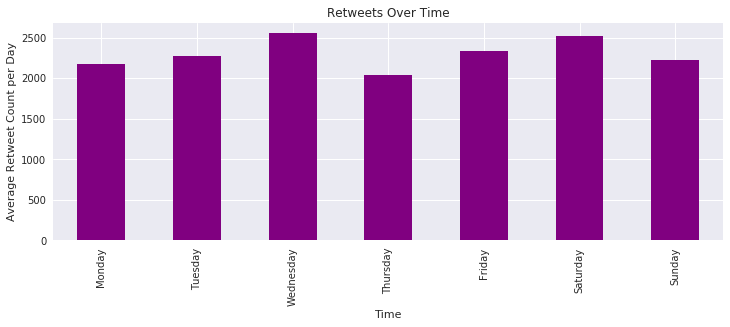

In [96]:
#a visualization of retweet_count over time
fig, axs = plt.subplots(figsize=(12, 4))
df_all.groupby(df_all["timestamp"].dt.dayofweek)["retweet_count"].mean().plot(kind='bar', rot=90, ax=axs, color="purple")
plt.xlabel("Time")
plt.xticks([0,1,2,3,4,5,6],["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("Average Retweet Count per Day")
plt.title("Retweets Over Time");

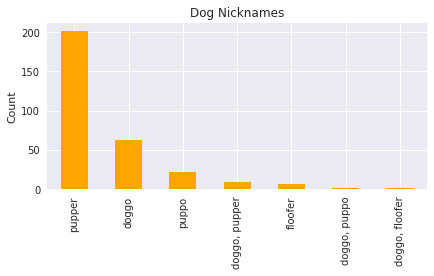

In [98]:
#visualization of dog nickname count
values=df_all.dog_stage.value_counts().sort_values()
df_all.dog_stage.value_counts().plot(kind="bar", title="Dog Nicknames", color="orange")
plt.tight_layout()
plt.xticks(rotation=90)
plt.ylabel("Count");